<a href="https://colab.research.google.com/github/mx60s/neural-computation/blob/main/Module_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Environment Setup

In [ ]:
!pip install numpy matplotlib

# Neural Decoding Schemes

In this notebook, we're going to be covering a few different ways to decode the underlying stimulus from the responses of a neural population.

In class, we discussed the case of the cricket's cercal system, which encodes the wind direction across the full directional spectrum.

![Cercal responses](https://mvonebers.com/cercal-responses.png)


This system can be described through just four interneurons, each of which respond at about 90 degree difference from each other.

We're going to try out 3 different schemes for decoding:
1. Winner-take-all approach
2. Population vector decoder
3. Probabilistic inference

First, let's set up our neurons.

We're going to use von Mises distributions this time instead of Gaussians, since this distribution is defined on the circle, so it's better for our circular direction scheme. It's pretty similar to the circular analogue of the Gaussian.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import vonmises

# Define the range our functions to be evaluated over
deg = np.linspace(-100, 430, 100)

# Parameters for the von Mises curves
neuron_preferences = np.array([60, 150, 240, 330]) # mean in degrees
kappas = [2] * 4                                   # kappa is the "spread"
max_amplitudes = [1] * 4
params = zip(neuron_preferences, kappas, max_amplitudes)

# Define the von Mises function with mu in degrees
def vonmises_pdf_degrees(x_degrees, mu_degrees, kappa, amplitude=2):
    x_radians = np.radians(x_degrees)
    mu_radians = np.radians(mu_degrees)
    return amplitude * vonmises.pdf(x_radians, kappa, loc=mu_radians)

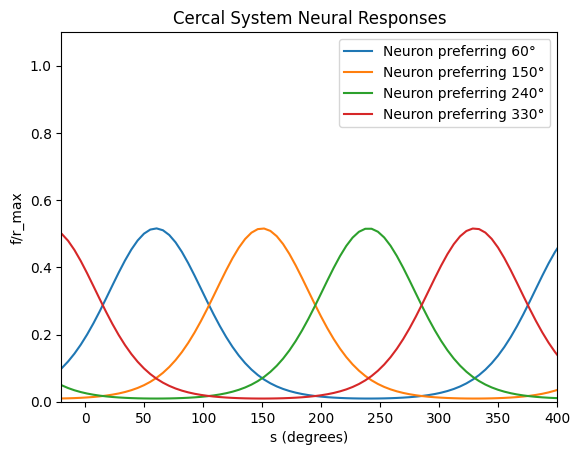

In [ ]:
fig, ax = plt.subplots()

# Plot each von Mises curve
for mu_degrees, kappa, amplitude in params:
    ax.plot(deg, vonmises_pdf_degrees(deg, mu_degrees, kappa, amplitude), label=f'Neuron preferring {mu_degrees}°')

ax.set_xlabel('s (degrees)')
ax.set_ylabel('f/r_max')
ax.set_title('Cercal System Neural Responses')

# Set the limits
ax.set_xlim(-20, 400)
ax.set_ylim(0, 1.1)

ax.legend()
plt.show()


The simplest way of decoding wind direction in this case would be to just say: whatever neuron is responding the most is the correct one, and its preferred wind direction is the current wind direction. This is pretty coarse, but it's a good place to start.

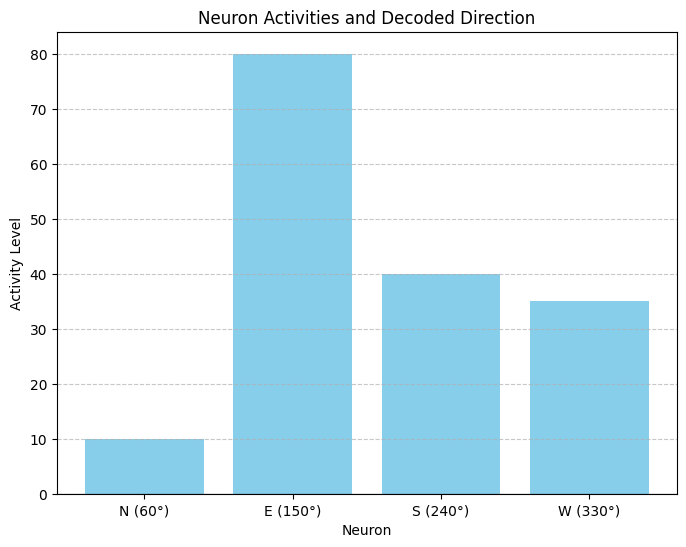


Decoded direction from winner-takes-all: 150°


In [ ]:
def decode_direction(neuron_activities):
    max_index = np.argmax(neuron_activities)
    return neuron_preferences[max_index]

# Example spike counts for each neuron across one timestep
neuron_activities = np.array([10, 80, 40, 35])

max_index = np.argmax(neuron_activities)
decoded_direction = neuron_preferences[max_index]

# Plotting
plt.figure(figsize=(8, 6))
plt.bar(range(4), neuron_activities, color='skyblue')
plt.xticks(range(4), ['N (60°)', 'E (150°)', 'S (240°)', 'W (330°)'])
plt.title('Neuron Activities and Decoded Direction')
plt.xlabel('Neuron')
plt.ylabel('Activity Level')
plt.axhline(0, color='black',linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print()
print(f'Decoded direction from winner-takes-all: {decoded_direction}°')


## Population Vector Decoding

Now let's start to take into consideration the influence of all of the neuron responses. We have a set of directions: the preferred orientations of the neurons. We also have a set of magnitudes we can use to weight these directions: the firing activity. If we take these vectors and sum them, we can get the direction of the resulting population vector.

In [ ]:
normalized_activities = neuron_activities / np.sum(neuron_activities)

# Convert preferred directions to radians for calculations
neuron_directions_radians = np.radians(neuron_preferences)

# Convert directions to unit vectors (cos(theta), sin(theta))
neuron_vectors = np.array([np.cos(neuron_directions_radians), np.sin(neuron_directions_radians)])

# Compute weighted contributions
weighted_vectors = neuron_vectors * normalized_activities

# Compute population vector by summing the weighted contributions
v_pop = np.sum(weighted_vectors, axis=1)


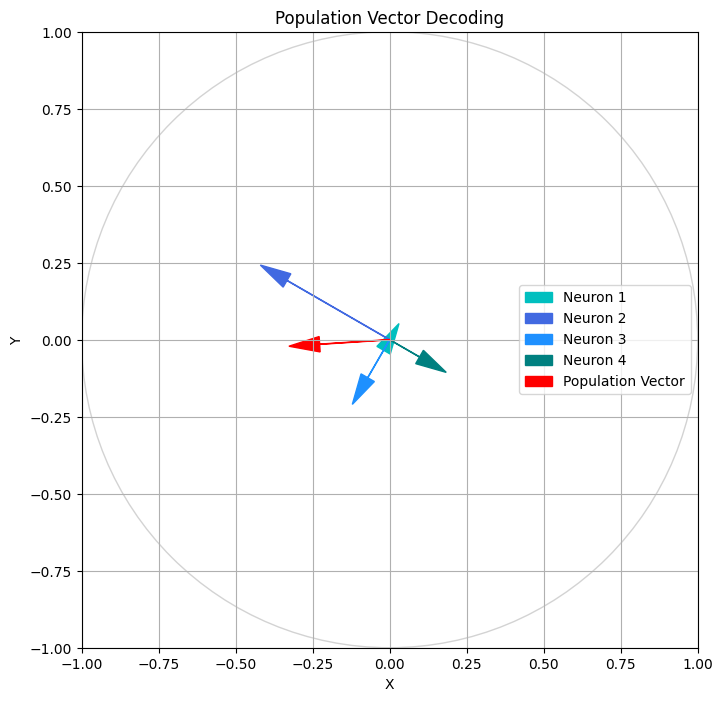


Decoded direction from population vector:  183.69°


In [ ]:
# Set up our plot
plt.figure(figsize=(8, 8))
ax = plt.gca()  # create axes

# Plot unit circle
circle = plt.Circle((0, 0), 1, color='lightgray', fill=False)
ax.add_artist(circle)

# Plot the vectors that each neuron represents
colors = ['c', 'royalblue', 'dodgerblue', 'teal']
for i, vec in enumerate(neuron_vectors.T):
    ax.arrow(0, 0, vec[0]*normalized_activities[i], vec[1]*normalized_activities[i],
             head_width=0.05, head_length=0.1, fc=colors[i], ec=colors[i], length_includes_head=True,
             label=f'Neuron {i+1}')

# Plot population vector
ax.arrow(0, 0, v_pop[0], v_pop[1], head_width=0.05, head_length=0.1, fc='red', ec='red', length_includes_head=True,
         label='Population Vector')

plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.title('Population Vector Decoding')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Calculate the angle of the population vector in degrees
'''
v_pop[0] and v_pop[1] are the calculated sin and cos components of the population
vector. We use arctangent to get the angle of this new vector in radians, then translate to degrees.
Finally, we use the modulo (%) operation to keep this number within the 0-360 range.
'''

pop_vector_angle = np.degrees(np.arctan2(v_pop[1], v_pop[0])) % 360

print()
print(f'Decoded direction from population vector: {pop_vector_angle: .2f}°')

So this is better, but we have our neurons represented as distributions, and we've so far only been using their activation values and means. What if we want to take into account the fact that they're probability distributions?

## Probabilistic Inference: MLE

Next, we're going to decode the position using the more principled **maximum likelihood estimation**.

For each possible wind direction, we calculate the probability of observing the actual neuron response: P(each neuron's activation | wind direction). Then we multiply this by the actual neuron activities: P(neuron activating | wind direction) * P(neuron activating), and sum it up. (We're also making sure to tweak our zero probabilities and take the log so that we don't have any underflow issues).

This sum represents how likely this wind direction is given the probability distributions of the stimuli. To find our final value, we just take the most likely wind direction out of this list.

We're also going to be looking at some neural activity over time now. So we'll get the expected spiking rate from our von Mises neurons under each possible wind direction, and then we'll sample a Poisson to get the probability of observing the recorded number of spikes from that neuron.

In [ ]:
from scipy.stats import poisson
from scipy.optimize import minimize_scalar

# Spike counts for each neuron across 10 timesteps
neural_activity = [
    (5, 20, 13, 2),
    (3, 19, 17, 4),
    (2, 12, 23, 10),
    (5, 4, 20, 18),
    (8, 4, 19, 22),
    (10, 6, 8, 18),
    (16, 8, 3, 15),
    (20, 8, 3, 10),
    (23, 16, 5, 8),
    (19, 19, 6, 3)
]

neuron_preferences_rad = np.radians(neuron_preferences)
kappa = 2

def expected_firing_rate(direction, neuron_index):
  # evaluate our pdf at at this direction to get an expected firing rate
    preferred_direction = neuron_preferences_rad[neuron_index]
    return vonmises.pdf(np.radians(direction), kappa, loc=preferred_direction)

def poisson_likelihood(direction, spike_counts):
    likelihood = 1
    for i, count in enumerate(spike_counts):
        # Calculate expected firing rate for this neuron and direction
        expected_rate = expected_firing_rate(direction, i)

        # Update the likelihood with the Poisson probability of observing 'count' given 'expected_rate'
        likelihood *= poisson.pmf(count, expected_rate)
    return -likelihood  # Negative likelihood for minimization

direction_range = np.linspace(0, 360, 1000)

decoded_directions = []

for spikes in neural_activity:
    likelihoods = np.array([poisson_likelihood(direction, spikes) for direction in direction_range])
    best_direction_index = np.argmin(likelihoods)
    best_direction = direction_range[best_direction_index]
    decoded_directions.append(best_direction)

print('Decoded directions:')
print('====================')
for i, deg in enumerate(decoded_directions):
  print(f't={i} : {deg: .2f}°')


Decoded directions:
t=0 :  174.05°
t=1 :  193.15°
t=2 :  234.59°
t=3 :  282.88°
t=4 :  298.38°
t=5 :  339.46°
t=6 :  31.35°
t=7 :  53.33°
t=8 :  83.96°
t=9 :  110.99°


Let's set up an animation in the same way we've done in a previous notebook, and take a look at how the neural population activity and decoded wind direction change over time.

In [ ]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Set up the figure and axes
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)

# Bar graph for neural activity
neuron_ids = np.arange(len(neuron_preferences))
bars = ax1.bar(neuron_ids, neural_activity[0], color='skyblue')
ax1.set_xticks(neuron_ids)
ax1.set_xticklabels(neuron_preferences)
ax1.set_ylim(0, max(max(activity) for activity in neural_activity) + 5)
ax1.set_ylabel('Spike Counts')
ax1.set_title('Neural Activity')

# Polar plot for wind direction
ax2 = fig.add_subplot(122, polar=True)  # Second subplot as polar
direction_line, = ax2.plot([0, np.radians(decoded_directions[0])], [0, 1], marker='o', color='red')
ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_ylim(0, 1)
ax2.set_title('Decoded Wind Direction')

def update(frame):
    # Update neural activity bars
    for bar, height in zip(bars, neural_activity[frame]):
        bar.set_height(height)

    # Update decoded direction line
    direction_line.set_xdata([0, np.radians(decoded_directions[frame])])

    return [direction_line, ]

# Create animation
ani = FuncAnimation(fig, update, frames=len(neural_activity), blit=True, interval=500, repeat=False)

display(HTML(ani.to_html5_video()))
plt.close(fig)

So this is the most accurate answer so far. Still, this is operating under the assumption that every wind position is equally likely. If we have information about the weather, we can decode more accurately.

### Extension: Bayesian Estimation

For the last part of this notebook, let's imagine that our cricket lives in Galveston. In our objective to find the correct wind direction, we can use the neural activity we've been using, but we can also use our prior knowledge that during the day, the wind tends to come off the water from the southeast.

Let's assume that we have a prior distribution which lies around 150 degrees.



In [ ]:
def expected_firing_rate(direction, neuron_index):
    # evaluate our pdf at at this direction to get an expected firing rate
    preferred_direction = neuron_preferences_rad[neuron_index]
    return vonmises.pdf(np.radians(direction), kappa, loc=preferred_direction)

def poisson_likelihood(direction, spike_counts):
    likelihood = 1
    for i, count in enumerate(spike_counts):
        # Calculate expected firing rate for this neuron and direction
        expected_rate = expected_firing_rate(direction, i)

        # Update the likelihood with the Poisson probability of observing 'count' given 'expected_rate'
        likelihood *= poisson.pmf(count, expected_rate)
    return -likelihood  # Negative likelihood for minimization

def posterior_probability(wind_direction, activities, neuron_preferences, prior_mean=0, prior_kappa=10):
    """
    Compute the posterior probability for a given wind direction using von Mises distributions for both
    the likelihood and the prior.
    """
    prior = vonmises_pdf_degrees(wind_direction, prior_mean, prior_kappa, amplitude=1)
    likelihood = poisson_likelihood(wind_direction, activities)
    return likelihood * prior

prior_mean_direction = 0

neuron_preferences = np.array([60, 150, 240, 330])
neuron_preferences_rad = np.radians(neuron_preferences)
kappa = 2
candidate_directions = np.linspace(0, 360, 1000)

bayesian_estimates = []

for spikes in neural_activity:
    posterior_probabilities = np.array([posterior_probability(wd, spikes, neuron_preferences, prior_mean=prior_mean_direction) for wd in candidate_directions])
    posterior_probabilities /= np.sum(posterior_probabilities)  # Normalize
    bayesian_estimate = candidate_directions[np.argmax(posterior_probabilities)]
    bayesian_estimates.append(bayesian_estimate)

print('The effect of our prior:')
print('-----------------------------')
print('     MLE estimate   Bayesian')
print('=============================')
for i, deg in enumerate(zip(decoded_directions, bayesian_estimates)):
  mle, bayes = deg
  print(f't={i} : {mle: .2f}°     {bayes: .2f}°')

The effect of our prior:
-----------------------------
     MLE estimate   Bayesian
t=0 :  174.05°      172.25°
t=1 :  193.15°      197.12°
t=2 :  234.59°      247.21°
t=3 :  282.88°      295.50°
t=4 :  298.38°      309.19°
t=5 :  339.46°      345.59°
t=6 :  31.35°      23.78°
t=7 :  53.33°      41.80°
t=8 :  83.96°      70.27°
t=9 :  110.99°      96.94°


In [ ]:
# Set up the figure and axes
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(121)

# Bar graph for neural activity
neuron_ids = np.arange(len(neuron_preferences))
bars = ax1.bar(neuron_ids, neural_activity[0], color='skyblue')
ax1.set_xticks(neuron_ids)
ax1.set_xticklabels(neuron_preferences)  # Changed to neuron IDs for clarity
ax1.set_ylim(0, max(max(activity) for activity in neural_activity) + 5)
ax1.set_ylabel('Spike Counts')
ax1.set_title('Neural Activity')

# Polar plot for wind direction
ax2 = fig.add_subplot(122, polar=True)

# Bayesian estimate line
bayesian_estimate_line, = ax2.plot([0, np.radians(bayesian_estimates[0])], [0, 1], marker='o', color='red', label='Bayesian Estimate')
# MLE decoded direction line
mle_decoded_line, = ax2.plot([0, np.radians(decoded_directions[0])], [0, 1], marker='o', color='green', label='MLE Decoded')
# Static line for prior direction
ax2.plot([np.radians(prior_mean_direction), np.radians(prior_mean_direction)], [0, 1], color='blue', linestyle='--', label='Prior Direction')

ax2.set_theta_zero_location('N')
ax2.set_theta_direction(-1)
ax2.set_ylim(0, 1)
ax2.set_title('Decoded Wind Direction')
ax2.legend(loc='upper right')

def update(frame):
    # Update neural activity bars
    for bar, height in zip(bars, neural_activity[frame]):
        bar.set_height(height)

    # Update Bayesian estimate direction line
    bayesian_estimate_line.set_xdata([0, np.radians(bayesian_estimates[frame])])
    # Update MLE decoded direction line
    mle_decoded_line.set_xdata([0, np.radians(decoded_directions[frame])])

    return [bayesian_estimate_line, mle_decoded_line]

ani = FuncAnimation(fig, update, frames=len(neural_activity), blit=True, interval=500, repeat=False)

display(HTML(ani.to_html5_video()))
plt.close(fig)